In [137]:
import numpy as np
import pytz
import datetime
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
# import nltk
# nltk.download('sentiwordnet')
# from nltk.corpus import sentiwordnet as swn
# from nltk.corpus import wordnet as wn
# from nltk.tag import pos_tag
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

PST_TZ = pytz.timezone('America/Los_Angeles')

GOHAWKS = "tweet_data/tweets_#gohawks.txt"
GOPATRIOTS = "tweet_data/tweets_#gopatriots.txt"
NFL = "tweet_data/tweets_#nfl.txt"
PATRIOTS = "tweet_data/tweets_#patriots.txt"
SB49 = "tweet_data/tweets_#sb49.txt"
SUPERBOWL = "tweet_data/tweets_#superbowl.txt"
ALL_FILES = [GOHAWKS, GOPATRIOTS, NFL, PATRIOTS, SB49, SUPERBOWL]
ALL_HASHTAGS = ["#gohawks", "#gopatriots", "#nfl", "#patriots", "#sb49", "#superbowl"]

In [3]:
# def GetJSONData(filepath):
#     with open(filepath, encoding="utf8") as fp:
#         data = [json.loads(line) for line in fp]
#     return data

def GetSampleJSON(filepath):
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            data = json.loads(line)
            break
    return data
    
def GetTweetStats(filepath):
    followers = 0
    retweets = 0
    data_len = 0
    count = 1
    res = []
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            followers += tweet['author']['followers']
            retweets += tweet['metrics']['citations']['total']
            data_len += 1
            if first_tweet:
                first_time = tweet['firstpost_date']
                first_datetime = datetime.datetime.fromtimestamp(first_time)
                next_time = first_datetime + datetime.timedelta(hours=1)
                first_tweet = False
            else:
                last_time = tweet['firstpost_date']
                last_datetime = datetime.datetime.fromtimestamp(last_time)
                if last_datetime > next_time:
                    while last_datetime >= next_time:
                        next_time = next_time + datetime.timedelta(hours=1)
                        res.append(count)
                        count = 0
                    count = 1
                else:
                    count += 1
    
    res.append(count)
    followers /= float(data_len)
    retweets /= float(data_len)
    
    time_diff = last_datetime - first_datetime
    num_hours = divmod(time_diff.total_seconds(), 3600)[0]
    tweets_per_hour = float(data_len) / num_hours
    
    return tweets_per_hour, followers, retweets, res

In [20]:
sample_data = GetSampleJSON(GOHAWKS)
print(json.dumps(sample_data, indent=2))

{
  "firstpost_date": 1419804875,
  "title": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
  "url": "http://twitter.com/Mich_Fit/status/549327579782840320",
  "tweet": {
    "contributors": null,
    "truncated": false,
    "text": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
    "in_reply_to_status_id": null,
    "id": 549327579782840320,
    "favorite_count": 1,
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "retweeted": false,
    "coordinates": null,
    "entities": {
      "symbols": [],
      "media": [
        {
          "expanded_url": "http://twitter.com/Mich_Fit/status/549327579782840320/photo/1",
          "sizes": {
            "large": {
              "h": 511,
              "resize": "fit",
              "w": 511
            },
            "small": {
              "h": 340,
              "resize": "fit",
              "w": 340
            },
            "medium": {
              "h": 511,
              "re

In [4]:
nfl_counts = []
superbowl_counts = []
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    stats = GetTweetStats(file)
    print("Statisics for", hashtag)
    print("Average tweets per hour:", stats[0])
    print("Average followers per tweet:", stats[1])
    print("Average retweets per tweet:", stats[2])
    print()
    if hashtag == "#nfl":
        nfl_counts = stats[3]
    elif hashtag == "#superbowl":
        superbowl_counts = stats[3]

Statisics for #gohawks
Average tweets per hour: 173.99382716049382
Average followers per tweet: 2217.9237355281984
Average retweets per tweet: 2.0132093991319877

Statisics for #gopatriots
Average tweets per hour: 34.42313323572474
Average followers per tweet: 1427.2526051635405
Average retweets per tweet: 1.4081919101697078

Statisics for #nfl
Average tweets per hour: 251.64362850971924
Average followers per tweet: 4662.37544523693
Average retweets per tweet: 1.5344602655543254

Statisics for #patriots
Average tweets per hour: 449.61326530612246
Average followers per tweet: 3280.4635616550277
Average retweets per tweet: 1.7852871288476946

Statisics for #sb49
Average tweets per hour: 1277.7474226804125
Average followers per tweet: 10374.160292019487
Average retweets per tweet: 2.52713444111402

Statisics for #superbowl
Average tweets per hour: 1268.3521421107628
Average followers per tweet: 8814.96799424623
Average retweets per tweet: 2.3911895819207736



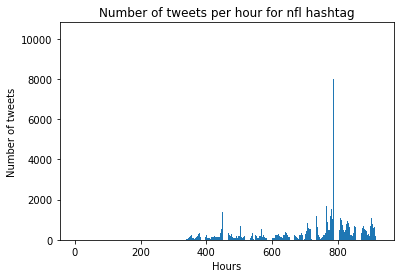

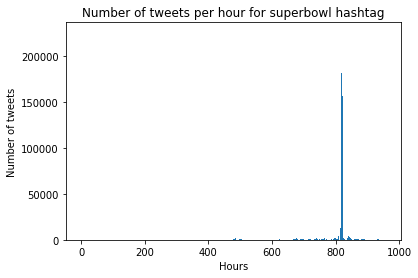

In [22]:
plt.bar(range(len(nfl_counts)), nfl_counts)
plt.title("Number of tweets per hour for nfl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()
plt.bar(range(len(superbowl_counts)), superbowl_counts)
plt.title("Number of tweets per hour for superbowl hashtag")
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.show()

In [6]:
happy_emoticons = [":)", ":-)", ":’)", ":]", "=]"]
sad_emoticons = [":(", ":-(", ":’(", ":[", "=["]
basic_feature_len = 5
total_feature_len = 16

def UpdateFeatureHistory(tweet, history):
    hashtags = [t for t in tweet['title'].split() if t.startswith('#')]
    for h in hashtags:
        if h.lower() == history['hashtags'][0] and h not in history['hashtags']:
            history['hashtags'].append(h)
            
    if 'unique_author_count' not in history:
        history['unique_author_count'] = 0
        history['authors'] = set()
        
    nameid = tweet['author']['name'] + tweet['author']['nick']
    if nameid not in history['authors']:
        history['authors'].add(nameid)
        history['unique_author_count'] += 1
        
#     tokens = nltk.tokenize.word_tokenize(tweet['title'])
#     stop = stopwords.words('english')
    
#     if 'pos_score' not in history:
#         history['pos_score'] = 0.0
#         history['neg_score'] = 0.0
    
#     pos_map = {"N" : 'n', "V" : 'v', "J" : 'a', "R" : 'r'}
#     text = []
#     for word in tokens:
#         if word not in stop and word[0] != '#' and not word.startswith("http"):
#             text.append(word)
#     text = pos_tag(text)
#     for word, pos in text:
#         c = pos[0]
#         if c not in pos_map:
#             continue
            
#         lemma = lemmatizer.lemmatize(word, pos=pos_map[c])
#         if not lemma:
#             continue
            
#         synsets = wn.synsets(word, pos=pos_map[c])
#         if not synsets:
#             continue

#         sent = swn.senti_synset(synsets[0].name())
#         history['pos_score'] += sent.pos_score()
#         history['neg_score'] += sent.neg_score()
    
    return history
        
def UpdateFeature(feature, tweet, cur_datetime, history={}):
    feature[0] += 1 # number of tweets in window
    feature[1] += tweet['metrics']['citations']['total'] # number of retweets
    feature[2] += tweet['author']['followers'] # number of followers
    feature[3] = max(feature[3], tweet['author']['followers']) # max number of followers per post
    feature[4] = cur_datetime.hour # hour of the day
    if len(feature) == total_feature_len:
        history = UpdateFeatureHistory(tweet, history)
        feature[5] += tweet['title'].count('@') # mention count
        feature[6] += 1 if tweet['title'].count("http") > 0 else 0 # url count
        feature[7] += (0 if all([tweet['title'].count(emote) == 0 for emote in happy_emoticons]) else 1) # tweets with happy emote
        feature[8] += (0 if all([tweet['title'].count(emote) == 0 for emote in sad_emoticons]) else 1) # tweets with sad emote
        feature[9] += tweet['title'].count("#") - 1 # number of additional hashtags
        feature[10] = len(history['hashtags'][0]) # length of hashtag
        feature[11] = len(history['hashtags']) # number of case-sensitive variations
        feature[12] = history['unique_author_count'] # unique number of authors
#         feature[16] = history['pos_score'] # positive sentiment score
#         feature[17] = history['neg_score'] # negative sentiment score
    return feature, history

def FinalizeFeature(feature):
    if len(feature) == total_feature_len and feature[0] != 0:
        feature[6] /= float(feature[0]) # change url count to url ratio
        feature[13] = float(feature[1]) / feature[0] # add retweet ratio
        feature[14] = float(feature[5]) / feature[0] # add mention ratio
        feature[15] = float(feature[12]) / feature[0] # add unique author ratio
#         feature[16] /= float(feature[0]) # avg pos score
#         feature[17] /= float(feature[0]) # avg neg score
    return feature
    
def GetDataTargets(data):
    targets = []
    for idx in range(len(data)-1):
        targets.append(data[idx+1][0])
    targets.append(0)
    return targets
    
def GetDataFeatures(filepath, hashtag="", piece_wise=False):
    td = datetime.timedelta(hours=1)
    data = []
    boundarys = []
    feature_len = basic_feature_len if hashtag == "" else total_feature_len
    history = {}
    history['hashtags'] = [hashtag]
    cur_feature = np.zeros(feature_len)
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            cur_time = tweet['firstpost_date']
            cur_datetime = datetime.datetime.fromtimestamp(cur_time, PST_TZ)
            if first_tweet:
                end_time = cur_datetime.replace(second=0, microsecond=0, minute=0) + td
                cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                first_tweet = False
            else:
                if cur_datetime < end_time:
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                else:
                    while cur_datetime >= end_time:
                        end_time += td
                        data.append(FinalizeFeature(cur_feature))
                        cur_feature = np.zeros(feature_len)
                        history = {}
                        history['hashtags'] = [hashtag]
                        if piece_wise:
                            if end_time.month == 2 and end_time.day == 1 and end_time.hour == 8 and end_time.minute == 0:
                                td = datetime.timedelta(minutes=5)
                                boundarys.append(len(data))
                            elif end_time.month == 2 and end_time.day == 1 and end_time.hour == 20 and end_time.minute == 0:
                                td = datetime.timedelta(hours=1)
                                boundarys.append(len(data))
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
    data.append(cur_feature)
    targets = GetDataTargets(data)
    data = np.array(data)
    targets = np.array(targets)
    if piece_wise:
        data = [data[:boundarys[0]], data[boundarys[0]+1:boundarys[1]], data[boundarys[1]+1:]]
        targets = [targets[:boundarys[0]], targets[boundarys[0]+1:boundarys[1]], targets[boundarys[1]+1:]]
    return data, targets

In [12]:
def ScoreOLS(data, targets, verbose=True, return_model=False, printps=True):
    data = sm.add_constant(data)
    model = sm.OLS(targets, data)
    results = model.fit()
    
    preds = results.predict(data)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    if verbose:
        print("mse:", mse)
        print("r2:", r2)
        if printps:
            print("tvalues:", results.tvalues)
            print("pvalues:", results.pvalues)
    if return_model:
        return results

In [13]:
for file, hashtag in zip(ALL_FILES, ALL_HASHTAGS):
    data, targets = GetDataFeatures(file)
    print("Results for", hashtag)
    print("data shape:", data.shape)
    ScoreOLS(data, targets)
    print()

Results for #gohawks
data shape: (973, 5)
mse: 453578.74861399474
r2: 0.4859092761755248
tvalues: [ 1.08077764 10.44064355 -4.07835853 -2.9768586   0.65304     1.37735108]
pvalues: [2.80065503e-01 2.97508596e-24 4.90865442e-05 2.98474171e-03
 5.13885719e-01 1.68722443e-01]

Results for #gopatriots
data shape: (684, 5)
mse: 21831.47522865118
r2: 0.653971081911064
tvalues: [ 0.17076797 -1.59989195  8.02088091 -3.604888    2.54022053 -0.18773757]
pvalues: [8.64457165e-01 1.10088401e-01 4.61673254e-15 3.35183637e-04
 1.13002596e-02 8.51138550e-01]

Results for #nfl
data shape: (927, 5)
mse: 173049.88794530474
r2: 0.6014683557318541
tvalues: [ 2.01563501  5.58944403 -3.53909633  4.94821016 -3.34897774  2.39503814]
pvalues: [4.41281846e-02 3.00072288e-08 4.21575799e-04 8.90288019e-07
 8.44009171e-04 1.68175348e-02]

Results for #patriots
data shape: (981, 5)
mse: 2786511.1091143223
r2: 0.7080068674117341
tvalues: [  1.05038766  21.65141621 -12.11920832   6.65463573  -1.31312292
   1.00209429

In [14]:
gohawks_data, gohawks_targets = GetDataFeatures(GOHAWKS, "#gohawks")
print("Results for #gohawks")
print("data shape:", gohawks_data.shape)
ScoreOLS(gohawks_data, gohawks_targets)

Results for #gohawks
data shape: (973, 16)
mse: 330299.9075028313
r2: 0.6256347568175098
tvalues: [ 7.25701319e-03 -4.03389902e+00 -2.38422264e+00 -3.92733025e+00
  1.95517417e+00 -6.77233034e-01 -4.89324029e-01 -1.01206166e-01
 -2.90423550e+00  9.54651216e+00  8.01078294e+00 -8.38225671e-01
  2.37625906e+00  2.23330478e+00  8.60169803e-01 -4.33989395e-01
  2.88460358e-01]
pvalues: [9.94211306e-01 5.92341486e-05 1.73094625e-02 9.20651955e-05
 5.08535727e-02 4.98421956e-01 6.24724560e-01 9.19408023e-01
 3.76626186e-03 1.08277541e-20 3.30070260e-15 4.02113494e-01
 1.76853261e-02 2.57595847e-02 3.89911104e-01 6.64394064e-01
 7.73056902e-01]


In [15]:
gopatriots_data, gopatriots_targets = GetDataFeatures(GOPATRIOTS, "#gopatriots")
print("Results for #gopatriots")
print("data shape:", gopatriots_data.shape)
ScoreOLS(gopatriots_data, gopatriots_targets)

Results for #gopatriots
data shape: (684, 16)
mse: 6416.508595213122
r2: 0.8982983282688985
tvalues: [  0.08796315  -2.47107699   1.51756654   9.91691012 -11.33160107
  -0.17389969  19.71687763  -0.82795446 -19.8236465    2.86467041
   8.07069981  -2.717644     0.80460701 -11.39790054  -0.91045565
  -4.03100146   3.14836454]
pvalues: [9.29932367e-01 1.37194560e-02 1.29597509e-01 1.02452533e-21
 2.41066444e-27 8.61997062e-01 1.56016680e-68 4.07992431e-01
 4.10857983e-69 4.30573970e-03 3.26033415e-15 6.74556120e-03
 4.21333188e-01 1.27616459e-27 3.62911158e-01 6.19462580e-05
 1.71510623e-03]


In [16]:
nfl_data, nfl_targets = GetDataFeatures(NFL, "#nfl")
print("Results for #nfl")
print("data shape:", nfl_data.shape)
ScoreOLS(nfl_data, nfl_targets)

Results for #nfl
data shape: (927, 16)
mse: 96243.55439001656
r2: 0.7783523443055502
tvalues: [ 1.80231284e-02  8.11582186e+00  4.63444034e-01 -2.47572230e+00
  2.46210770e+00 -2.02870372e+00  5.02723222e+00 -1.74930415e+00
  4.00141554e+00  2.30342439e+00  1.27267607e+01 -2.48697168e+00
  1.48815326e+00 -1.98282189e+01 -1.46636423e+00 -1.08790033e+00
  6.38827582e+00]
pvalues: [9.85624353e-01 1.55775641e-15 6.43156943e-01 1.34777204e-02
 1.39967311e-02 4.27792250e-02 5.99200848e-07 8.05755609e-02
 6.80829959e-05 2.14796309e-02 2.88864109e-34 1.30618038e-02
 1.37056916e-01 5.26676725e-73 1.42894550e-01 2.76927154e-01
 2.67357820e-10]


In [17]:
patriots_data, patriots_targets = GetDataFeatures(PATRIOTS, "#patriots")
print("Results for #patriots")
print("data shape:", patriots_data.shape)
ScoreOLS(patriots_data, patriots_targets)

Results for #patriots
data shape: (981, 16)
mse: 2221685.164195578
r2: 0.7671938903826823
tvalues: [ 2.12247347e-03 -7.96857448e-01  2.71267542e+00  9.27450478e+00
 -6.62960254e+00  3.20617412e-01  4.48286231e+00 -1.03868395e+00
 -5.84542034e+00  1.67017529e-01  1.87199214e+00  1.84557531e+00
 -3.74902313e+00 -9.79019548e-01 -1.21088037e+00  1.27714822e+00
  2.06179798e-01]
pvalues: [9.98306952e-01 4.25730035e-01 6.79314147e-03 1.13974243e-19
 5.59582395e-11 7.48569828e-01 8.24947815e-06 2.99212199e-01
 6.91006424e-09 8.67391283e-01 6.15102938e-02 6.52603945e-02
 1.88090497e-04 3.27815945e-01 2.26238034e-01 2.01857442e-01
 8.36694003e-01]


In [18]:
sb49_data, sb49_targets = GetDataFeatures(SB49, "#sb49")
print("Results for #sb49")
print("data shape:", sb49_data.shape)
ScoreOLS(sb49_data, sb49_targets)

Results for #sb49
data shape: (583, 16)
mse: 11787020.632727424
r2: 0.8575058568709029
tvalues: [ 2.11574343e-03 -1.94219542e+00  4.21913798e+00  7.86353444e-02
  1.16084164e+00 -6.04388690e-01  1.00785684e+01  3.20077205e-01
  9.20179274e+00 -3.01432154e+00  5.20197106e+00 -4.01037053e-01
 -3.44934139e-01 -4.87995416e+00 -2.41064346e+00  1.11923907e+00
  5.29609032e-01]
pvalues: [9.98312628e-01 5.26091539e-02 2.85576035e-05 9.37350466e-01
 2.46195665e-01 5.45827440e-01 4.39637732e-22 7.49027926e-01
 6.73850086e-19 2.69090907e-03 2.76067761e-07 6.88544194e-01
 7.30272023e-01 1.38163040e-06 1.62421157e-02 2.63512912e-01
 5.96590697e-01]


In [19]:
superbowl_data, superbowl_targets = GetDataFeatures(SUPERBOWL, "#superbowl")
print("Results for #superbowl")
print("data shape:", superbowl_data.shape)
ScoreOLS(superbowl_data, superbowl_targets)

Results for #superbowl
data shape: (959, 16)
mse: 22603641.061547738
r2: 0.8588953569572297
tvalues: [ 2.11410691e-04  6.62195160e+00 -2.09526488e+00 -8.26119382e+00
  7.05244444e+00 -1.36631581e+00 -3.34311973e+00  1.73783465e-01
  2.00691468e+00 -7.21613345e+00  1.25615124e+01 -3.81152823e-01
 -3.81296601e+00 -8.77113560e+00  5.61322812e-01  4.75000722e-01
  1.01175223e+00]
pvalues: [9.99831363e-01 5.94786572e-11 3.64139519e-02 4.85692393e-16
 3.40067000e-12 1.72165916e-01 8.61056274e-04 8.62072977e-01
 4.50440789e-02 1.09976076e-12 1.42720669e-33 7.03175800e-01
 1.46240079e-04 8.16160104e-18 5.74710999e-01 6.34896566e-01
 3.11916334e-01]


In [20]:
all_measures = ["number of tweets", "number of retweets", "number of followers", "max number of followers", 
               "hour of the day", "mention count", "url ratio", "happy emote count", "sad emote count",
               "number of extra hashtags", "length of hashtag", "number of case-sensitive variations", "unique author count",
               "retweet ratio", "mention ratio", "author ratio", "positive sentiment score", "negative sentiment score"]

def PlotPValues(data, target, model, hashtag):
    pvalues = model.pvalues
    inds = np.argsort(pvalues)[:3] - 1
    for i in range(3):
        print("pvalue:", pvalues[inds[i]+1])
        print("coefficient:", model.params[inds[i]+1])
        plt.scatter(data[:, inds[i]], target)
        plt.title("{} vs target for {}".format(all_measures[inds[i]], hashtag))
        plt.xlabel(all_measures[inds[i]])
        plt.ylabel("Number of tweets in next hour")
        plt.show()

pvalue: 1.0827754083574978e-20
coefficient: 340.2934075970114


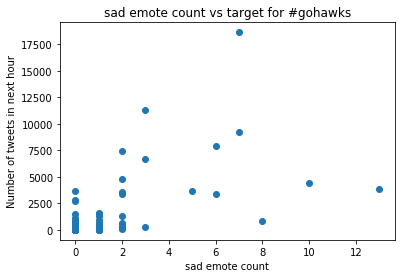

pvalue: 3.3007026004195017e-15
coefficient: 1.608416745935025


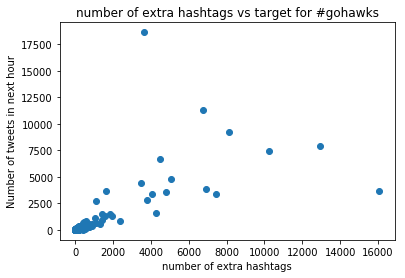

pvalue: 5.923414856764107e-05
coefficient: -1.3479651169105682


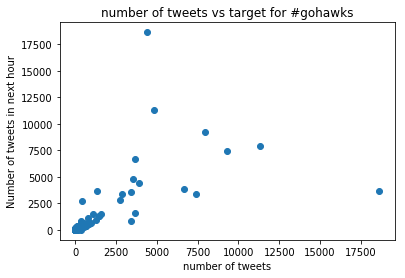

In [21]:
model = ScoreOLS(gohawks_data, gohawks_targets, verbose=False, return_model=True)
PlotPValues(gohawks_data, gohawks_targets, model, "#gohawks")

pvalue: 4.1085798260508503e-69
coefficient: -152.90625490207196


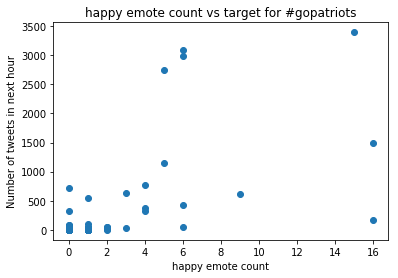

pvalue: 1.5601667979993539e-68
coefficient: 7.962510360323975


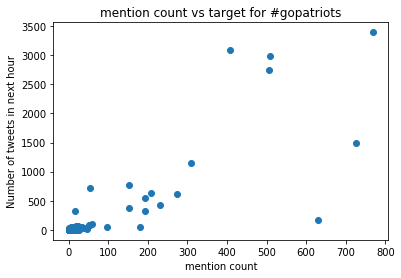

pvalue: 1.2761645871976947e-27
coefficient: -4.250039609143718


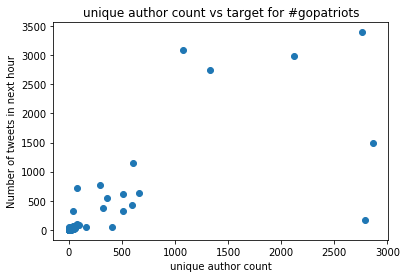

In [22]:
model = ScoreOLS(gopatriots_data, gopatriots_targets, verbose=False, return_model=True)
PlotPValues(gopatriots_data, gopatriots_targets, model, "#gopatriots")

pvalue: 5.266767250548962e-73
coefficient: -4.640467698295142


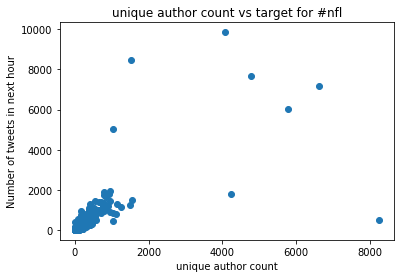

pvalue: 2.888641085144953e-34
coefficient: 0.937153657854677


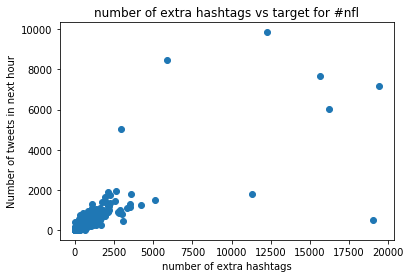

pvalue: 1.5577564124155443e-15
coefficient: 1.58845260249316


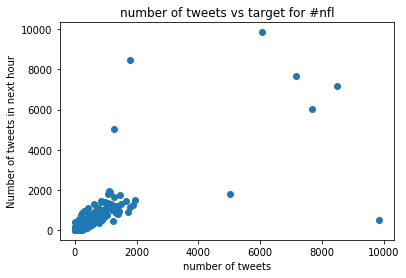

In [23]:
model = ScoreOLS(nfl_data, nfl_targets, verbose=False, return_model=True)
PlotPValues(nfl_data, nfl_targets, model, "#nfl")

pvalue: 1.1397424325090598e-19
coefficient: 0.00045287046844767607


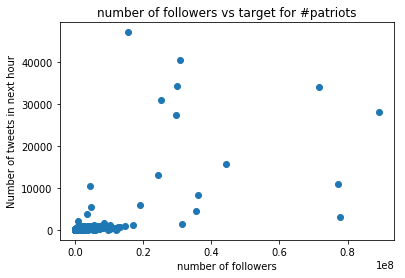

pvalue: 5.595823950617835e-11
coefficient: -0.0005635459151861768


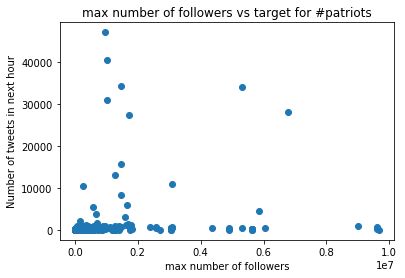

pvalue: 6.910064244475494e-09
coefficient: -199.42934817815953


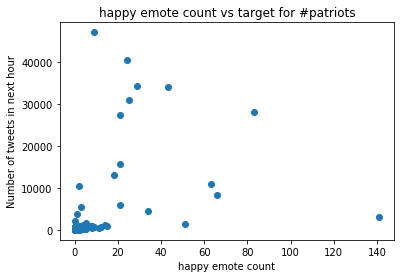

In [24]:
model = ScoreOLS(patriots_data, patriots_targets, verbose=False, return_model=True)
PlotPValues(patriots_data, patriots_targets, model, "#patriots")

pvalue: 4.3963773186234935e-22
coefficient: 3.0242464825265825


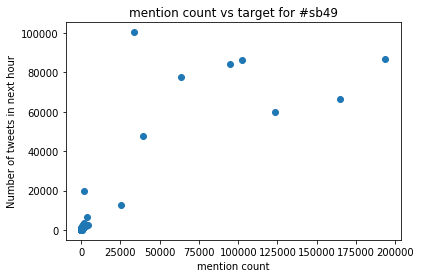

pvalue: 6.738500855396772e-19
coefficient: 651.950889869807


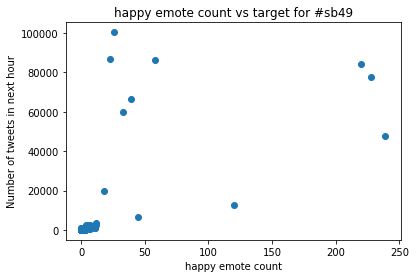

pvalue: 2.760677607931109e-07
coefficient: 2.2489820188571414


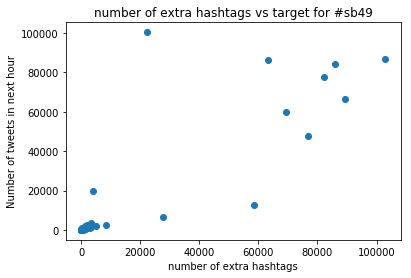

In [25]:
model = ScoreOLS(sb49_data, sb49_targets, verbose=False, return_model=True)
PlotPValues(sb49_data, sb49_targets, model, "#sb49")

pvalue: 1.4272066859256836e-33
coefficient: 4.731419808508724


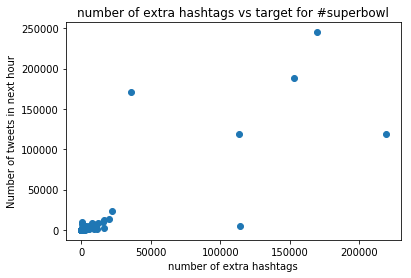

pvalue: 8.161601042133037e-18
coefficient: -4.7359578817685986


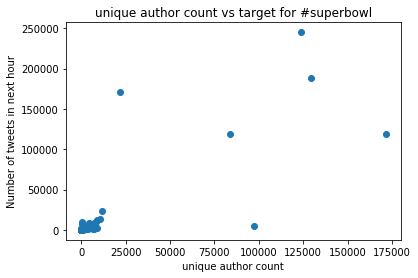

pvalue: 4.856923933127093e-16
coefficient: -0.00013963991685718454


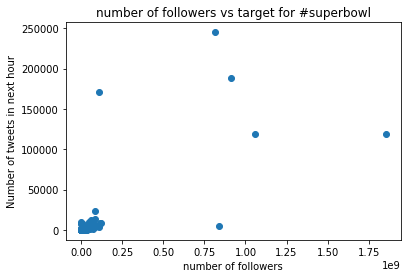

In [26]:
model = ScoreOLS(superbowl_data, superbowl_targets, verbose=False, return_model=True)
PlotPValues(superbowl_data, superbowl_targets, model, "#superbowl")

In [27]:
def GetPieceWiseOLS(datafile, hashtag, printps=False):
    datap, targetsp = GetDataFeatures(datafile, hashtag, piece_wise=True)
    print("Results for", hashtag)
    for i in range(3):
        print("Time interval:", i+1)
        print("data shape:", datap[i].shape)
        ScoreOLS(datap[i], targetsp[i], printps=printps)
        print()
    return datap, targetsp

In [28]:
gohawks_datap, gohawks_targetsp = GetPieceWiseOLS(GOHAWKS, "#gohawks", printps=False)

Results for #gohawks
Time interval: 1
data shape: (833, 16)
mse: 271375.445382461
r2: 0.514329993545904

Time interval: 2
data shape: (143, 16)
mse: 60163.390637118224
r2: 0.5754308683619143

Time interval: 3
data shape: (127, 16)
mse: 477.2147102396605
r2: 0.9520417533827094



In [29]:
gopatriots_datap, gopatriots_targetsp = GetPieceWiseOLS(GOPATRIOTS, "#gopatriots", printps=False)

Results for #gopatriots
Time interval: 1
data shape: (547, 16)
mse: 816.0768269847177
r2: 0.7536959469681632

Time interval: 2
data shape: (143, 16)
mse: 12402.085360497958
r2: 0.521018658756186

Time interval: 3
data shape: (124, 16)
mse: 9.325205382178705
r2: 0.9334412016258181



In [30]:
nfl_datap, nfl_targetsp = GetPieceWiseOLS(NFL, "#nfl", printps=False)

Results for #nfl
Time interval: 1
data shape: (779, 16)
mse: 33315.6413326962
r2: 0.6484421163339069

Time interval: 2
data shape: (143, 16)
mse: 16489.828140449263
r2: 0.8566773945615471

Time interval: 3
data shape: (135, 16)
mse: 14829.158233528085
r2: 0.8295244157635824



In [31]:
patriots_datap, patriots_targetsp = GetPieceWiseOLS(PATRIOTS, "#patriots", printps=False)

Results for #patriots
Time interval: 1
data shape: (833, 16)
mse: 158980.53614173608
r2: 0.6354641056037005

Time interval: 2
data shape: (143, 16)
mse: 597599.384736016
r2: 0.7451969099086138

Time interval: 3
data shape: (135, 16)
mse: 10113.21638358279
r2: 0.8727366263682212



In [32]:
sb49_datap, sb49_targetsp = GetPieceWiseOLS(SB49, "#sb49", printps=False)

Results for #sb49
Time interval: 1
data shape: (435, 16)
mse: 5552.573110082231
r2: 0.8940050125720045

Time interval: 2
data shape: (143, 16)
mse: 1096174.3937818054
r2: 0.885815537772451

Time interval: 3
data shape: (135, 16)
mse: 60863.90937327502
r2: 0.8311302759630507



In [33]:
superbowl_datap, superbowl_targetsp = GetPieceWiseOLS(SUPERBOWL, "#superbowl", printps=False)

Results for #superbowl
Time interval: 1
data shape: (811, 16)
mse: 239493.10602732404
r2: 0.5379453607842346

Time interval: 2
data shape: (143, 16)
mse: 3410216.117415681
r2: 0.9448128527054891

Time interval: 3
data shape: (135, 16)
mse: 114352.33469416547
r2: 0.837117820880704



In [34]:
import copy

def FinalizeMergedFeatures(feature):
    if len(feature) == total_feature_len and feature[0] != 0:
        feature[6] /= float(feature[0]) # change url count to url ratio
        feature[13] = float(feature[1]) / feature[0] # add retweet ratio
        feature[14] = float(feature[5]) / feature[0] # add mention ratio
        feature[15] = float(feature[12]) / feature[0] # add unique author ratio
#         feature[16] /= float(feature[0]) # avg pos score
#         feature[17] /= float(feature[0]) # avg neg score
    return feature
        
def MergeFeatures(feature, data_sample):
    feature[0] += data_sample[0]
    feature[1] += data_sample[1]
    feature[2] += data_sample[2]
    feature[3] = max(feature[3], data_sample[3])
    feature[4] = data_sample[4]
    if len(feature) == total_feature_len:
        feature[5] += data_sample[5]
        feature[6] += data_sample[6]
        feature[7] += data_sample[7]
        feature[8] += data_sample[8]
        feature[9] += data_sample[9]
        feature[10] += data_sample[10]
        feature[11] += data_sample[11]
        feature[12] = max(feature[12], data_sample[12])
    
    return feature
        
def MergeIntervals(all_data, all_targets):
    data_res = []
    target_res = []
    for i in range(3):
        data_interval_res = []
        target_interval_res = []
        for j in range(len(all_data[0][i])):
            feature = np.zeros(len(all_data[0][0][0]))
            target = 0
            for n in range(len(all_data)):
                feature = MergeFeatures(feature, all_data[n][i][j])
                target += all_targets[n][i][j]
            data_interval_res.append(FinalizeMergedFeatures(feature))
            target_interval_res.append(target)
        data_res.append(np.array(data_interval_res))
        target_res.append(np.array(target_interval_res))
    return data_res, target_res
        
def RescaleData(data):
    for i in range(len(data)):
        if data[i, 0] != 0:
            data[i, 6] *= data[i, 0]
            data[i, 13] *= data[i, 0]
            data[i, 14] *= data[i, 0]
            data[i, 15] *= data[i, 0]
    return data

def UndoFinalization(all_data):
    for i in range(len(all_data)):
        for j in range(3):
            if len(all_data[i][j][0]) == total_feature_len:
                all_data[i][j] = RescaleData(all_data[i][j])
    return all_data

def AggregateAllData(all_data, all_targets):
    n = len(all_data)
    all_data = copy.deepcopy(all_data)
    all_targets = copy.deepcopy(all_targets)
    prepend_lens = {0 : 0, 1 : 286, 2 : 54, 3 : 0, 4 : 398, 5 : 22}
    
    for i in range(n):
        if len(all_data[i][0]) == total_feature_len:
            all_data[i] = RescaleData(all_data[i])
        
    for i in range(n):
        all_data[i] = np.vstack((np.zeros((prepend_lens[i], len(all_data[i][0]))), all_data[i]))
        all_targets[i] = np.hstack((np.zeros(prepend_lens[i]), all_targets[i]))
    maxlen = max([len(all_data[i]) for i in range(6)])
    for i in range(n):
        l = len(all_data[i])
        if l < maxlen:
            all_data[i] = np.vstack((all_data[i], np.zeros((maxlen - l, len(all_data[i][0])))))
            all_targets[i] = np.hstack((all_targets[i], np.zeros(maxlen - l)))
    
    data_res = []
    target_res = []
    for j in range(len(all_data[0])):
        feature = np.zeros(len(all_data[0][0]))
        target = 0
        for i in range(n):
            feature = MergeFeatures(feature, all_data[i][j])
            target += all_targets[i][j]
        data_res.append(FinalizeMergedFeatures(feature))
        target_res.append(target)

    return np.array(data_res), np.array(target_res)
        
def MergePieceWiseData(all_data, all_targets):
    all_data = copy.deepcopy(all_data)
    all_targets = copy.deepcopy(all_targets)
    feature_len = len(all_data[0][0][0])
    max_interval1 = max([len(data[0]) for data in all_data])
    max_interval3 = max([len(data[2]) for data in all_data])
    all_data = UndoFinalization(all_data)
    for i in range(len(all_data)):
        l = len(all_data[i][0])
        if l < max_interval1:
            all_data[i][0] = np.vstack((np.zeros((max_interval1 - l, feature_len)), all_data[i][0]))
            all_targets[i][0] = np.hstack((np.zeros(max_interval1 - l), all_targets[i][0]))
        l = len(all_data[i][2])
        if l < max_interval3:
            all_data[i][2] = np.vstack((all_data[i][2], np.zeros((max_interval3 - l, feature_len))))
            all_targets[i][2] = np.hstack((all_targets[i][2], np.zeros(max_interval3 - l)))
    data, targets = MergeIntervals(all_data, all_targets)
    return data, targets

In [35]:
all_data, all_targets = AggregateAllData([gohawks_data, gopatriots_data, nfl_data, patriots_data, sb49_data, superbowl_data],
                                          [gohawks_targets, gopatriots_targets, nfl_targets, patriots_targets, sb49_targets, superbowl_targets])

In [36]:
print("Results for aggregated data")
print(all_data.shape)
print(all_targets.shape)
ScoreOLS(all_data, all_targets)

Results for aggregated data
(981, 16)
(981,)
mse: 32124023.07625771
r2: 0.9331432609094434
tvalues: [ -0.42681992  -0.57728923   8.00861564   7.17625029  -7.50807353
  -0.57082451  17.55554801  -0.63357336  -2.41893453   0.81417597
  13.07132211   2.97241103  -3.34124832 -38.5686349   -0.96021531
  -0.48449408   0.93805257]
pvalues: [6.69605798e-001 5.63878880e-001 3.32743548e-015 1.42852599e-012
 1.36443430e-013 5.68251640e-001 4.42729374e-060 5.26509580e-001
 1.57503364e-002 4.15745216e-001 4.58655092e-036 3.02815235e-003
 8.66055558e-004 1.36005906e-197 3.37187636e-001 6.28145326e-001
 3.48452353e-001]


In [50]:
all_datap, all_targetsp = MergePieceWiseData([gohawks_datap, gopatriots_datap, nfl_datap, patriots_datap, sb49_datap, superbowl_datap],
                                          [gohawks_targetsp, gopatriots_targetsp, nfl_targetsp, patriots_targetsp, sb49_targetsp, superbowl_targetsp])

In [51]:
print("Results for aggregated piecewise data")
for i in range(3):
    print("Interval {} data shape {}".format(i+1, all_datap[i].shape))
    print("Target shape:", all_targetsp[i].shape)
    ScoreOLS(all_datap[i], all_targetsp[i])
    print()

Results for aggregated piecewise data
Interval 1 data shape (833, 16)
Target shape: (833,)
mse: 1875421.031074804
r2: 0.5771227684213787
tvalues: [ 1.04993472e-01  8.07018710e-03  3.44456925e+00 -1.34931324e+00
 -1.14942323e+00 -1.56561209e+00  2.93157435e+00 -9.87780919e-01
 -6.57325334e+00  9.92080954e+00 -6.48657407e-01 -2.52660593e+00
  3.60351360e+00  1.95014365e+00 -5.81000796e-01 -8.93439951e-02
  1.32854579e+00]
pvalues: [9.16406791e-01 9.93562965e-01 6.01149207e-04 1.77610630e-01
 2.50718287e-01 1.17827155e-01 3.46671683e-03 3.23552753e-01
 8.77542413e-11 5.58917876e-22 5.16742341e-01 1.17050699e-02
 3.32966526e-04 5.15010915e-02 5.61400349e-01 9.28830454e-01
 1.84369279e-01]

Interval 2 data shape (143, 16)
Target shape: (143,)
mse: 11142088.38528958
r2: 0.9015660385837904
tvalues: [ 0.74183855  5.72365535 -2.34264689 -1.17430923  0.93602887  2.98819416
  2.7604072  -2.69586795  1.78683562 -0.77304156 -5.58894308 -0.32328833
  0.74463752  0.30856891  0.87240165  1.14319853 -0

In [52]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

param_grid = {
'max_depth': [10, 30, 50, 70, 100, 200, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 3, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [ ]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error")
search = clf.fit(all_data, all_targets)
print("Best params:")
print(clf.best_params_)
print("Best score:")
print(clf.best_score_)
print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
clf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error")
search = clf.fit(all_data, all_targets)
print("Best params:")
print(clf.best_params_)
print("Best score:")
print(clf.best_score_)
print()

In [ ]:
val_res = cross_val_score(LinearRegression(), all_data, all_targets, cv=5, scoring="neg_mean_squared_error")
print("OLS Score:", np.mean(val_res))

In [ ]:
for i in range(3):
    print("Interval", i+1)
    clf = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error")
    search = clf.fit(all_datap[i], all_targetsp[i])
    print("Best params:")
    print(clf.best_params_)
    print("Best score:")
    print(clf.best_score_)
    print()

In [132]:
# NN test run
def Score_nn(data, targets, sizez=(100, ), verbose=True):
    model = MLPRegressor(hidden_layer_sizes=sizez, max_iter=100000000000000000, tol=0.0000000001, batch_size = 800, learning_rate = 'adaptive')
    results = model.fit(data,targets)
    
    preds = results.predict(data)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    if verbose:
        print("mse:", mse)
        print("r2:", r2)
        return results
                         

                         
all_data, all_targets = AggregateAllData([gohawks_data, gopatriots_data, nfl_data, patriots_data, sb49_data, superbowl_data],
                                          [gohawks_targets, gopatriots_targets, nfl_targets, patriots_targets, sb49_targets, superbowl_targets])


Score_nn(all_data, all_targets)

mse: 2233532928.334881
r2: -3.6484441841351014


MLPRegressor(activation='relu', alpha=0.0001, batch_size=800, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000,
             max_iter=100000000000000000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=1e-10, validation_fraction=0.1,
             verbose=False, warm_start=False)

In [144]:
# problem 11

test_sizes = [(100, 100), (100, 100, 100), (100, 100, 100, 100), (500, 500), (500, 500, 500), (500, 500, 500, 500), (500, 400, 200, 100, 50, 16)]


for net_dim in test_sizes:
    print("Network size is ", net_dim)
    Score_nn(all_data, all_targets, sizez=net_dim)

Network size is  (100, 100)
mse: 1834453481873.7998
r2: -3816.877278952798
Network size is  (100, 100, 100)
mse: 277077132.4300265
r2: 0.42334515490604985
Network size is  (100, 100, 100, 100)
mse: 6413609261.278096
r2: -12.348047969961776
Network size is  (500, 500)
mse: 15977986184.370169
r2: -32.25349539766917
Network size is  (500, 500, 500)
mse: 261093581.11349013
r2: 0.456610232495288
Network size is  (500, 500, 500, 500)
mse: 197454578.2879955
r2: 0.5890561654902702
Network size is  (500, 400, 200, 100, 50, 16)
mse: 412202508.59359103
r2: 0.1421212871098133


In [76]:
Score_nn(all_data, all_targets, sizez=(500, 300, 500))

mse: 488906155.5958183
r2: -0.017514873739298498


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500, 300, 500), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [84]:
model = MLPRegressor(hidden_layer_sizes=(500, 500, 500), max_iter=1000000, batch_size = 800)
results = model.fit(all_data,all_targets)
    
preds = results.predict(all_data)
mse = mean_squared_error(all_targets, preds)
r2 = r2_score(all_targets, preds)
print(mse)

In [143]:
# question 12

scaler = StandardScaler()
scaler.fit(all_data)
scaled_all_data = scaler.transform(all_data)

Score_nn(scaled_all_data, all_targets, sizez=(500, 300, 500))


mse: 93136514.46959889
r2: 0.8061636416797391


MLPRegressor(activation='relu', alpha=0.0001, batch_size=800, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500, 300, 500), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000,
             max_iter=100000000000000000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=1e-10, validation_fraction=0.1,
             verbose=False, warm_start=False)

In [150]:
# question 13

from sklearn.model_selection import GridSearchCV, cross_val_score

all_datap, all_targetsp = MergePieceWiseData([gohawks_datap, gopatriots_datap, nfl_datap, patriots_datap, sb49_datap, superbowl_datap],
                                          [gohawks_targetsp, gopatriots_targetsp, nfl_targetsp, patriots_targetsp, sb49_targetsp, superbowl_targetsp])





nn_param_grid = {'hidden_layer_sizes': test_sizes
}

for period in np.arange(2):
    print('For period' , period+1)
    
    scaler = StandardScaler()
    scaler.fit(all_datap[period])
    scaled_all_data_p = scaler.transform(all_datap[period])
    
    clf = GridSearchCV(MLPRegressor( max_iter=1000), nn_param_grid, cv=5, scoring="neg_mean_squared_error")
    search = clf.fit(scaled_all_data_p, all_targetsp[period])
    print("Best params:")
    print(clf.best_params_)
    print("Best score:")
    print(clf.best_score_)

For period 1


C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Best params:
{'hidden_layer_sizes': (100, 100)}
Best score:
-2558789.318066154
For period 2


C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Best params:
{'hidden_layer_sizes': (500, 400, 200, 100, 50, 16)}
Best score:
-38558711.52802348


C:\Users\AJ\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [200]:
#question 14
from os import listdir

def GetDataFeatures_test(filepath, hashtag=""):
    if 'period2' in filepath:
        td = datetime.timedelta(minutes=5)
    else:
        td = datetime.timedelta(hours=1)
    data = []
    boundarys = []
    feature_len = basic_feature_len if hashtag == "" else total_feature_len
    history = {}
    history['hashtags'] = [hashtag]
    cur_feature = np.zeros(feature_len)
    first_tweet = True
    with open(filepath, encoding="utf8") as fp:
        for line in fp:
            tweet = json.loads(line)
            cur_time = tweet['firstpost_date']
            cur_datetime = datetime.datetime.fromtimestamp(cur_time, PST_TZ)
            if first_tweet:
                end_time = cur_datetime.replace(second=0, microsecond=0, minute=0) + td
                cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                first_tweet = False
            else:
                if cur_datetime < end_time:
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
                else:
                    while cur_datetime >= end_time:
                        end_time += td
                        data.append(FinalizeFeature(cur_feature))
                        cur_feature = np.zeros(feature_len)
                        history = {}
                        history['hashtags'] = [hashtag]
                    cur_feature, history = UpdateFeature(cur_feature, tweet, cur_datetime, history)
    data.append(cur_feature)
    targets = GetDataTargets(data)
    data = np.array(data)
    targets = np.array(targets)
    return data, targets

test_feat=np.array([])
test_target=np.array([])

names = listdir('tweet_test')
for name  in names:
    a, b = GetDataFeatures_test('tweet_test/'+name)
    test_feat=np.append(test_feat, a)
    test_target=np.append(test_target, b)

num_feat=a.shape[1]    
    
test_feat = test_feat.reshape(-1,num_feat)
print(test_target.shape)
print(test_feat.shape)



(66,)
(66, 5)


In [206]:
#question 14

from sklearn.ensemble import RandomForestRegressor


reg=RandomForestRegressor(n_estimators=1000,  max_depth=50)
reg.fit(all_data[:,:5], all_targets)
preds = reg.predict(test_feat)
mse = mean_squared_error(test_target, preds)
r2 = reg.score(test_feat, test_target)

print('mse: ', mse)
print('r2: ', r2)

mse:  4209088.169830594
r2:  -0.48059785921693937
